Cluster Centers: [[1.4719312  3.38091463]
 [3.61543255 9.02834011]
 [6.98366492 4.3837207 ]]
Cluster Membership: [1 0 2 1 2 2 0 1]
Final fuzzy partitioned matrix (u):
[[0.07047716 0.78803356 0.02604143 0.06971861 0.01117299 0.04899663
  0.91810337 0.0038823 ]
 [0.87440674 0.12133096 0.02515813 0.79183421 0.01339208 0.03304373
  0.03476709 0.99123913]
 [0.0551161  0.09063548 0.94880045 0.13844718 0.97543493 0.91795964
  0.04712954 0.00487856]]

Initial fuzzy partitioned matrix (u0):
[[0.17646383 0.6743763  0.22216275 0.52885296 0.18533144 0.54607616
  0.2086097  0.28406195]
 [0.82103848 0.26110487 0.52126505 0.25825486 0.35792012 0.42720891
  0.77339023 0.61770032]
 [0.00249769 0.06451883 0.2565722  0.21289218 0.45674844 0.02671492
  0.01800007 0.09823773]]

Distance matrix (d):
[[6.64011655 1.70302498 6.55735838 5.81233336 5.76029358 4.57019406
  1.45933008 6.16159495]
 [1.885138   4.34017815 6.67147929 1.7246769  5.26144665 5.56510253
  7.49920343 0.38561028]
 [7.50862898 5.02162486 1

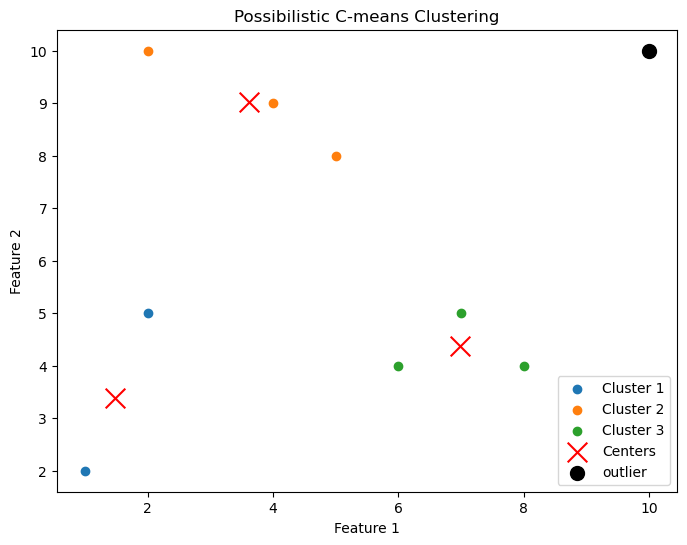

In [5]:
## Fuzzy C means Library
import numpy as np
import pandas as pd
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# Generate some example data
X  = pd.DataFrame([[2,10],
              [2,5],
              [8,4],
              [5,8],
              [7,5],
              [6,4],
              [1,2],
              [4,9]])

# Define the number of clusters
n_clusters = 3
data = X.values

# Apply fuzzy c-means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, n_clusters, 2, error=0.04, maxiter=1000, init=None
)

# Predict cluster membership for each data point
cluster_membership = np.argmax(u, axis=0)

# Print the cluster centers
print('Cluster Centers:', cntr)

# Print the cluster membership for each data point
print('Cluster Membership:', cluster_membership)

print('Final fuzzy partitioned matrix (u):')
print(u)

print('\nInitial fuzzy partitioned matrix (u0):')
print(u0)

print('\nDistance matrix (d):')
print(d)

print('\nObjective function history (jm):')
print(jm)

print('\nNumber of iterations run (p):')
print(p)

print('\nFuzzy partition coefficient (fpc):')
print(fpc)

# Plot the data and cluster centers
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    plt.scatter(data[cluster_membership == i, 0], data[cluster_membership == i, 1], label=f'Cluster {i+1}')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200, label='Centers')
plt.scatter(x=10,y=10, c='black', marker='o', s=100, label='outlier')
plt.title('Possibilistic C-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.savefig('pcmeans.jpg')
plt.show()

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


def update_noise_eta(u, d, m):

    u = u ** m
    d_2 = d**2
    n = np.sum(u * d_2, axis=1) / np.sum(u, axis=1)
    return n


def update_cluster_centers(x, u, m):
    um = u ** m
    v = um.dot(x.T) / np.atleast_2d(um.sum(axis=1)).T
    return v


def fcm_criterion(x, v, n, m, metric):

    d = cdist(x.T, v, metric=metric).T

    # Sanitize Distances (Avoid Zeroes)
    d = np.fmax(d, np.finfo(x.dtype).eps)

    exp = -2. / (m - 1)
    d2 = d ** exp

    u = d2 / np.sum(d2, axis=0, keepdims=1)
    return u, d


def pcm_criterion(x, v, n, m, metric):

    d = cdist(x.T, v, metric=metric)
    d = np.fmax(d, np.finfo(x.dtype).eps)

    d2 = (d ** 2) / n
    exp = 1. / (m - 1)
    d2 = d2.T ** exp
    u = 1. / (1. + d2)

    return u, d



In [47]:
def cmeans(x, c, m, e, max_iterations, criterion_function, metric="euclidean", v0=None, n=None):

    if not x.any() or len(x) < 1 or len(x[0]) < 1:
        print("Error: Data is in incorrect format")
        return

    # Num Features, Datapoints
    S, N = x.shape

    if not c or c <= 0:
        print("Error: Number of clusters must be at least 1")

    if not m or m <= 1:
        print("Error: Fuzzifier must be greater than 1")
        return

    # Initialize the cluster centers
    # If the user doesn't provide their own starting points,
    if v0 is None:
        # Pick random values from dataset
        xt = x.T
        v0 = xt[np.random.choice(xt.shape[0], c, replace=False), :]

    # List of all cluster centers (Bookkeeping)
    v = np.empty((max_iterations, c, S))
    v[0] = np.array(v0)

    # Membership Matrix Each Data Point in eah cluster
    u = np.zeros((max_iterations, c, N))

    # Number of Iterations
    t = 0

    while t < max_iterations - 1:

        u[t], d = criterion_function(x, v[t], n, m, metric)
        v[t + 1] = update_cluster_centers(x, u[t], m)

        # Stopping Criteria
        if np.linalg.norm(v[t + 1] - v[t]) < e:
            break

        t += 1

    return v[t], v[0], u[t - 1], u[0], d, t

In [49]:
def fcm(x, c, m, e, max_iterations, metric="euclidean", v0=None):

    return cmeans(x, c, m, e, max_iterations, fcm_criterion, metric, v0=v0)


def pcm(x, c, m, e, max_iterations, metric="euclidean", v0=None):
    v, v0, u, u0, d, t = fcm(x, c, m, e, max_iterations, metric=metric, v0=v0)
    n = update_noise_eta(u, d, m)
    return cmeans(x, c, m, e, t, pcm_criterion, metric, v0=v, n=n)

In [133]:
def plot_clusters(x, u, v, threshold=0.3):
    """
    Parameters:
    `x`: Dataset, size (S, N)
        Data to be clustered. N is the number of data sets; S is the number of features.
    
    `u`: Final Membership Matrix, size (C, N)
        Final partitioned matrix from PCM, where each value u[i,j] is the membership of data point j to cluster i.
    
    `v`: cluster centers, size (C, S)
        Final cluster centers from PCM.

    `threshold`: float
        Threshold for determining outliers based on membership values.
    """

    # Number of clusters and data points
    num_clusters, num_points = u.shape
    
    # Find the cluster with the highest membership for each point
    max_membership = np.max(u, axis=0)
    assigned_clusters = np.argmax(u, axis=0)
    
    # Initialize arrays to store clustered and outlier points
    clustered_points = [[] for _ in range(num_clusters)]
    outliers = []

    # Assign points to clusters or mark as outliers
    for i in range(num_points):
        if max_membership[i] >= threshold:
            clustered_points[assigned_clusters[i]].append(x[:, i])
        else:
            outliers.append(x[:, i])
            
    # Debugging: print how many points are classified in each cluster and how many are outliers
    for i in range(num_clusters):
        print(f"Number of points in Cluster {i+1}: {len(clustered_points[i])}")
    print(f"Number of outliers: {len(outliers)}")
    print(np.array(outliers))

    # Plot clusters
    colors = ['r', 'g', 'b', 'y', 'c', 'm'] 
    
    plt.figure(figsize=(10, 10))
    for i in range(num_clusters):
        if clustered_points[i]:  # Check if there are any points in this cluster
            cluster_data = np.array(clustered_points[i]).T
            plt.scatter(cluster_data[0, :], cluster_data[1, :], c=colors[i % len(colors)], marker='*', label=f'Cluster {i+1}')

    # Plot outliers in black
    if outliers:
        outlier_data = np.array(outliers).T
        plt.scatter(outlier_data[0, :], outlier_data[1, :], c='k', marker='x', label='Outliers')

    # Plot cluster centers
    plt.scatter(v[:, 0], v[:, 1], c='black', marker='o', s=100, label='Centroids')

    plt.title("PCM Clustering with Outliers")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()



Number of points in Cluster 1: 193
Number of points in Cluster 2: 190
Number of points in Cluster 3: 50
Number of outliers: 67
[[ 1.8535271  -0.7164187 ]
 [ 2.30801311  0.46793015]
 [ 1.78946151  1.01491329]
 [ 2.27959897 -0.05615094]
 [-1.23250997  0.92791687]
 [-1.13927763  0.39039385]
 [ 2.05623856 -0.02393825]
 [-1.40711338  0.85105181]
 [ 1.79274644  0.98775745]
 [ 2.51430833  0.23417652]
 [ 2.20170803 -0.43975416]
 [ 1.26548872  1.36369921]
 [-1.08073005  0.0040643 ]
 [ 2.43829239  0.14836706]
 [-1.33949112 -0.34690318]
 [-1.40195809  0.41978578]
 [ 2.47235568  0.11986877]
 [-0.71816533  1.7659488 ]
 [-1.09355336 -0.14711326]
 [ 2.5674341   0.84553024]
 [ 2.40579035  0.29741856]
 [-1.62238743  0.83446687]
 [ 2.22926924  0.37026282]
 [ 2.00443866 -0.44535636]
 [ 2.24929422  0.41282374]
 [-1.20166076 -0.18391643]
 [-1.13313494 -0.58678349]
 [-0.91914656  1.31188165]
 [-1.49012497 -0.082035  ]
 [-1.14067002  0.36774844]
 [ 2.21081291 -0.18745627]
 [ 1.21060366 -1.24634761]
 [ 2.1066

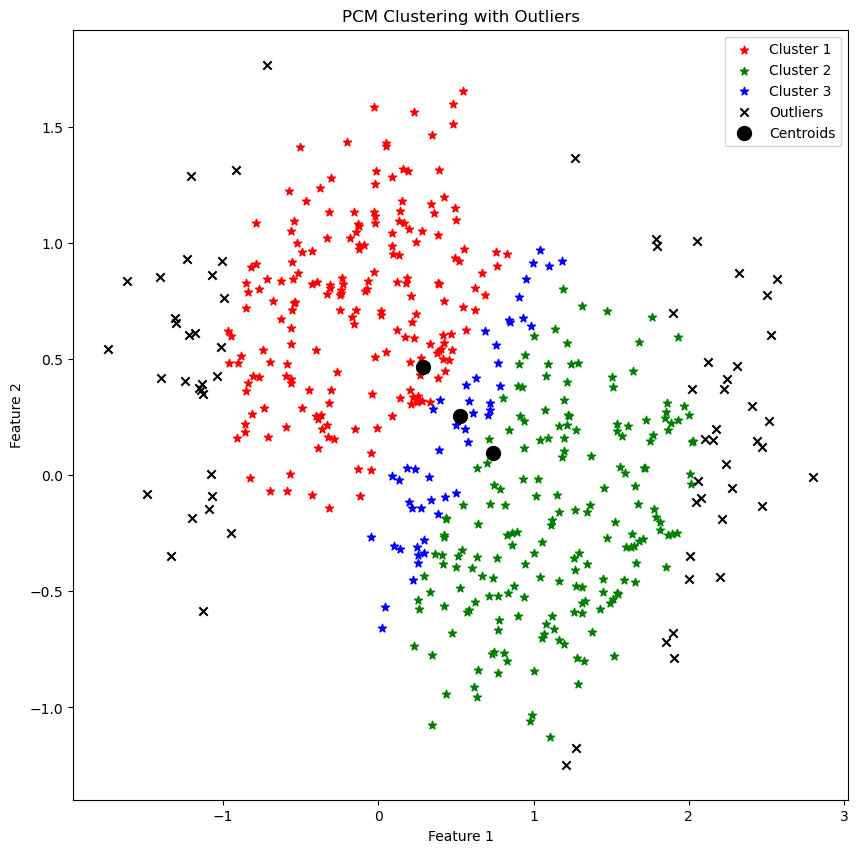

In [145]:
from sklearn.datasets import make_moons

# Generate a dataset with 500 points, with noise = 0.3
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)

# Transpose X to match the shape expected by PCM (features as rows, samples as columns)
X = X.T  # X now has shape (2, 500)


# Set the parameters for PCM
c = 3
m = 2.0
e = 0.01
max_iterations = 200

v, v0, u, u0, d, t = pcm(X, c, m, e, max_iterations)

# Plot the results
plot_clusters(X, u, v, threshold=0.2)


In [117]:
v

array([[0.93352925, 0.01440351],
       [0.1192598 , 0.55405525],
       [0.53741207, 0.23828149]])

In [123]:
np.set_printoptions(threshold=np.inf)
print(u.T)

[[0.81009334 0.23330186 0.57323073]
 [0.3140422  0.22074929 0.32316489]
 [0.63993483 0.14683038 0.334343  ]
 [0.15297965 0.59440523 0.28667587]
 [0.13660849 0.272221   0.20536567]
 [0.5085715  0.12163421 0.26327112]
 [0.89181198 0.18230531 0.44382525]
 [0.14123976 0.41163196 0.24119972]
 [0.42232295 0.70849154 0.84035382]
 [0.39422209 0.09824505 0.20085294]
 [0.99861333 0.23413571 0.59384615]
 [0.16599174 0.55525427 0.32398376]
 [0.24893227 0.07440377 0.14077825]
 [0.2553196  0.98521655 0.55616418]
 [0.42776439 0.10423897 0.21710421]
 [0.50912191 0.12093845 0.26169952]
 [0.28396948 0.09518712 0.17264731]
 [0.59496915 0.33296764 0.6343901 ]
 [0.37850672 0.1361998  0.27244504]
 [0.32335955 0.08840606 0.17212574]
 [0.33092262 0.10219524 0.19207754]
 [0.17471504 0.07193743 0.11857401]
 [0.16840599 0.55592704 0.32890798]
 [0.8791005  0.1847568  0.45160876]
 [0.42029528 0.747862   0.87534766]
 [0.19726364 0.10973987 0.16402978]
 [0.54986232 0.14555614 0.30218193]
 [0.10856904 0.35638886 0.19

In [125]:
d

array([[0.3085986 , 1.13635645, 0.56362785],
       [0.94198952, 1.17774271, 0.94534421],
       [0.47809485, 1.51102343, 0.92170034],
       [1.49975896, 0.51780511, 1.03040628],
       [1.60234648, 1.02494468, 1.2849326 ],
       [0.6265353 , 1.68450114, 1.09272997],
       [0.22199557, 1.3275699 , 0.7312405 ],
       [1.57162476, 0.74943068, 1.15860647],
       [0.74543812, 0.40208671, 0.28471397],
       [0.79009193, 1.89911121, 1.30297137],
       [0.02375084, 1.13371414, 0.54021785],
       [1.42867458, 0.56101104, 0.94357746],
       [1.10710888, 2.21092902, 1.61378421],
       [1.08851462, 0.07678625, 0.58353952],
       [0.73718504, 1.83756414, 1.24044772],
       [0.62584576, 1.69000863, 1.09717455],
       [1.0120951 , 1.9326436 , 1.4299671 ],
       [0.52588188, 0.8872253 , 0.49589689],
       [0.81671927, 1.57862831, 1.06746603],
       [0.92199277, 2.01289521, 1.43258335],
       [0.90628821, 1.85796312, 1.33969877],
       [1.38525016, 2.25150361, 1.78097896],
       [1.